In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [ ]:
from scipy.optimize import minimize

In [ ]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        self.resid = []
        self.resid.append(y)
        self.trees = []
        self.y_pred = []
        
        for _ in range(self.n_estimators):
            self.y_pred.append(self._fit_predict_tree(x, self.resid[-1]))
            
            self.resid.append(y - np.sum(self.y_pred, axis = 0))

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth = self.max_depth).fit(x, y)
        
        fun = lambda z: mean_squared_error(self.resid[-1], z * tree.predict(x))
        
        self.gamma = minimize(fun, 0.1).x
        
        self.trees.append((tree, self.gamma))
            
        return self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = np.zeros(len(x))
        
        for tree in self.trees:
            y_pred += tree[0].predict(x)*self.learning_rate*tree[1]
        
        return y_pred

In [ ]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [ ]:
np.random.seed(19052019)

bgt = GradientBoosting(385, 6, 0.035800235)
bgt.fit(X_train, y_train)
y_pred = bgt.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred)

9.520788200182755

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [ ]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [ ]:
# Референс

from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

C:\Users\Nazim\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7056112711172605

In [ ]:
from catboost import CatBoostClassifier

param_test = {
    #'depth': np.arange(1, 15, 1),
    #'learning_rate': np.arange(0.0, 1.1, 0.1),
    #'iterations': np.arange(1, 11, 1)
    #'leaf_estimation_iterations': np.arange(1, 11, 1),
    #'l2_leaf_reg': np.arange(0.0, 1.1, 0.1)
    #'bagging_temperature': np.arange(1,11,1)
    'early_stopping_rounds': np.arange(1,300,10)
}
gsearch = GridSearchCV(estimator = CatBoostClassifier(iterations = 100,learning_rate=0.8, depth = 12, leaf_estimation_iterations = 2, loss_function='CrossEntropy'), 
                         param_grid = param_test, scoring='roc_auc',n_jobs=4, iid=False, cv=5)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

C:\Users\Nazim\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


0:	learn: 0.4625510	total: 270ms	remaining: 26.7s
1:	learn: 0.4465649	total: 385ms	remaining: 18.9s
2:	learn: 0.4446173	total: 489ms	remaining: 15.8s
3:	learn: 0.4437841	total: 610ms	remaining: 14.6s
4:	learn: 0.4431846	total: 730ms	remaining: 13.9s
5:	learn: 0.4426850	total: 851ms	remaining: 13.3s
6:	learn: 0.4421801	total: 964ms	remaining: 12.8s
7:	learn: 0.4416526	total: 1.08s	remaining: 12.5s
8:	learn: 0.4410184	total: 1.2s	remaining: 12.2s
9:	learn: 0.4407219	total: 1.31s	remaining: 11.8s
10:	learn: 0.4404531	total: 1.42s	remaining: 11.5s
11:	learn: 0.4400458	total: 1.53s	remaining: 11.3s
12:	learn: 0.4397670	total: 1.64s	remaining: 11s
13:	learn: 0.4392208	total: 1.76s	remaining: 10.8s
14:	learn: 0.4387466	total: 1.88s	remaining: 10.6s
15:	learn: 0.4382849	total: 1.99s	remaining: 10.4s
16:	learn: 0.4378364	total: 2.1s	remaining: 10.2s
17:	learn: 0.4375069	total: 2.21s	remaining: 10.1s
18:	learn: 0.4370619	total: 2.31s	remaining: 9.86s
19:	learn: 0.4365951	total: 2.41s	remaining: 

({'early_stopping_rounds': 1}, 0.6920097801270895)

In [ ]:
cbc_model = CatBoostClassifier(learning_rate=0.83, 
                               depth = 12, 
                               leaf_estimation_iterations = 2, 
                               loss_function='CrossEntropy', 
                               early_stopping_rounds = 1,
                               bagging_temperature = 1,
                               metric_period = 200,
                               )
cbc_model.fit(X_train, y_train)
roc_auc_score(y_valid, cbc_model.predict_proba(X_valid)[:, 1])

0:	learn: 0.4602221	total: 101ms	remaining: 1m 40s
200:	learn: 0.3963923	total: 19.3s	remaining: 1m 16s
400:	learn: 0.3734326	total: 37.5s	remaining: 56s
600:	learn: 0.3579520	total: 54.9s	remaining: 36.5s
800:	learn: 0.3449968	total: 1m 12s	remaining: 18.1s
999:	learn: 0.3347100	total: 1m 28s	remaining: 0us


0.8750680292812494

In [ ]:
from scipy.spatial import distance

In [ ]:
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        
    def fit_predict(self, X):
        self.X = X
        self.cluster = np.zeros(self.X.shape[0])
        self.clss = 1
        for x in range(self.X.shape[0]):  
            if self.cluster[x] == 0:
                neighb = self.range_query(x)
                if len(neighb) < self.min_samples:
                    self.cluster[x] = -1
                else: 
                    self.cluster[x] = self.clss
                    self.grow_cluster(x, neighb)
                    self.clss += 1
                    
        return self.cluster
        
    def grow_cluster(self, root, neighbours):
        queue = set()
        queue.update(neighbours)
        
        while queue:
            vertex = queue.pop()
            if self.cluster[vertex] != self.clss:
                self.cluster[vertex] = self.clss
                
                neig = self.range_query(vertex)
                if len(neig) >= self.min_samples:
                    queue.update(self.range_query(vertex))

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        mask = list(map(lambda z: self.dist(z, self.X[x]), self.X))
        indx = [index for index, value in enumerate(mask) if value <= self.eps]
        return indx
        
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        return distance.euclidean(a, b)
        

Проверим себя на простом примере:

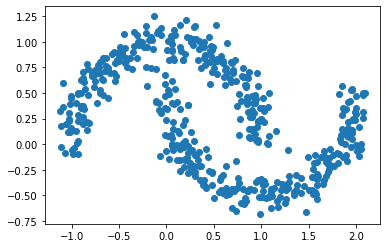

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

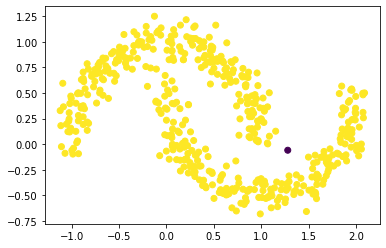

In [ ]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

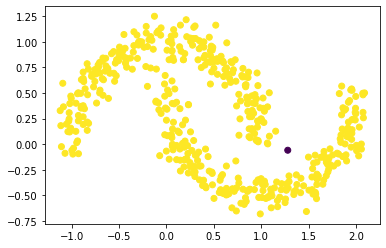

In [ ]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

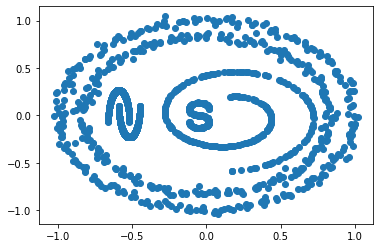

In [ ]:
from sklearn.datasets import make_circles
from sklearn.datasets import make_s_curve
from sklearn.datasets import make_swiss_roll

K, _ = make_circles(n_samples=500, noise=0.025, factor = 0.83)
Z, _ = make_moons(n_samples=1000, noise=0)
Y, _ = make_s_curve(n_samples=200, noise=0.03)
W, _ = make_swiss_roll(n_samples=300, noise=0)

Z[:,0], Z[:,1] = (-1/14*Z[:,0] - 0.52), (-1/3*Z[:,1] + 0.1)

Y = Y[:,[-1,0]]

Y[:,0], Y[:,1] = (1/15*Y[:,1]- 0.05), (1/15*Y[:,0])

W = W[:,[-1,0]]

W[:,0], W[:,1] = (1/22*W[:,1] + 0.15), (-1/24*W[:,0]) 

X = np.vstack((K, Z, Y, W))
plt.scatter(X[:,0], X[:,1])
plt.show()

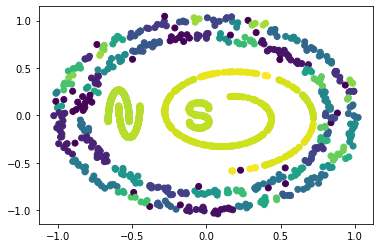

In [ ]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.05, min_samples=2).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

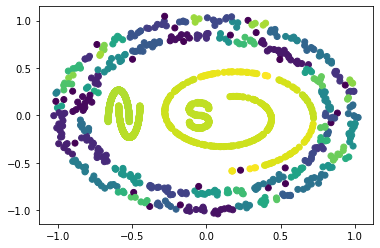

In [ ]:
clusters = dbscan(eps=0.05, min_samples=2).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

In [ ]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 45.9 ms


In [ ]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 1min 35s
